In [99]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from utils import read_data
import seaborn as sns
import pandas as pd

In [100]:
def getBoxPlot(row):
    des = row.describe()
    upper_quartile = des["75%"]
    lower_quartile = des["25%"]
    iqr = upper_quartile - lower_quartile

    upper_whisker = row[row <= (upper_quartile + 1.5 * iqr)].max()
    lower_whisker = row[row >= (lower_quartile - 1.5 * iqr)].min()
    return lower_whisker, upper_whisker

In [101]:
def getData(modelName, mode, cutoffRow=None):
    if mode == "TRAIN":
        sourceFolder = "o7_analyze_train"
    elif mode == "TEST":
        sourceFolder = "o7_analyze_test"
    else:
        raise ValueError("Unknown mode")
    sourceFolder = os.path.join(sourceFolder, modelName)

    cwd = sys.path[0]
    outputFolderPath = os.path.join(cwd, sourceFolder)
    folderNames = os.listdir(outputFolderPath)

    data = {}
    for folderName in folderNames:
        folderPath = os.path.join(outputFolderPath, folderName)
        data_pickle, data_json = read_data(folderPath)
        valueArray = data_pickle["mapeArray"]
        data[folderName] = valueArray

    tArrayPred = data_pickle["tArrayPred"]
    df = pd.DataFrame(data=data, index=tArrayPred)

    if cutoffRow is not None:
        df = df.iloc[:cutoffRow, :]

    # Create long form data
    dft = df.copy()
    dft["time"] = dft.index
    value_vars = [col for col in dft.columns.values if col != "time"]
    dfLong = pd.melt(
        dft, id_vars=["time"], value_vars=value_vars, var_name="folder", value_name="value"
    )
    dfLong["model"] = modelName

    # Create wide form data
    dfWide = df.copy()
    dfWide["mean"] = dfWide.apply(lambda row: row.describe()["mean"], axis=1)
    dfWide["std"] = dfWide.apply(lambda row: row.describe()["std"], axis=1)
    dfWide["25%"] = dfWide.apply(lambda row: row.describe()["25%"], axis=1)
    dfWide["75%"] = dfWide.apply(lambda row: row.describe()["75%"], axis=1)
    dfWide["lower_whisker"] = dfWide.apply(lambda row: getBoxPlot(row)[0], axis=1)
    dfWide["upper_whisker"] = dfWide.apply(lambda row: getBoxPlot(row)[1], axis=1)
    dfWide["median"] = dfWide.apply(lambda row: row.median(), axis=1)

    return df, dfLong, dfWide


In [102]:
mode = "TEST"
modelNames = ["p2", "p4", "p8", "p16", "m1", "m2", "m4", "m8", "m16", "m32"]

In [103]:
cutoffRow = 50
dfLongArray = []
for modelName in modelNames:
    df, dfLong, dfWide = getData(modelName, mode, cutoffRow=cutoffRow)
    dfLongArray.append(dfLong)

dfLongAppended = pd.concat(dfLongArray)


In [104]:
dfLongAppended.shape

(16450, 4)

<Axes: xlabel='model', ylabel='value'>

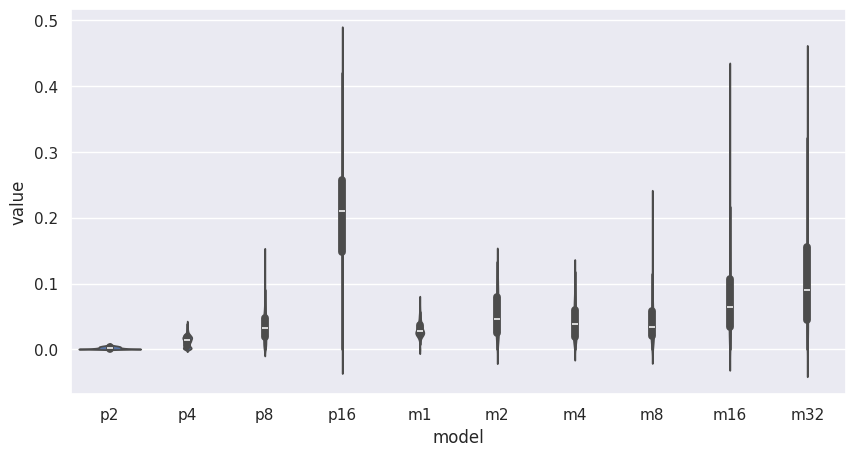

In [108]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,5))
sns.violinplot(data=dfLongAppended, x="model", y="value", ax=ax)